# Data wrangling‬ for 311 Service requests

## Objective:

   Data wrangling and visualization tasks will be performed to ensure that raw data is transformed into a‬ clean format and then visualized effectively to develop valuable insights. Data wrangling‬ involves handling null values by imputing mean or median values in missing values of columns longitude‬ or latitude‬. Duplicate records are identified and removed, standardizing data types to‬ ensure consistency, such as converting Floating Timestamp to datetime for the date columns‬. Data transformations like encoding categorical variables (e.g., encoding status description “open”=> 0 and “closed” => 1) and normalizing numerical data for easier analysis. Feature engineering to derive‬ new columns, such as calculating response time (e.g., the difference between closed date and‬ requested date will be the response time), and additionally, grouping and mapping subdivisions into‬ broader categories, such as combining detailed service name into high-level service groups for providing‬ clearer insights‬. When unusual values are found in numerical columns, these are outliers,‬ which can be treated by capping or removal to prevent skewed results‬.
    

In [1240]:
#!pip install geopandas


In [1241]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

import numpy as np
import re
import pandas as pd
from tabulate import tabulate
import geopandas as gpd

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

import plotly.express as px

from datetime import datetime
import pytz

### Part 1: Data Cleaning and Preprocessing

### 1.1 Load and Inspect the Dataset

• Load data: Load the dataset and display its shape, column names, and data types.

• Inspect data: Identify and list the number of missing values in each column.

### 1.2 Handling Missing and Unwanted Data

• Handling Missing Data: Drop columns with more than 10% missing values.

• Handling Unwanted Data: Drop requestes created before Jan-1-2023 and after Dec-31-2024.

• Handling Missing Community Code: Fill Community Code with Community name.

• Handling Missing Longitude: Fill Longitude with Median value.

• Handling Missing Latitude: Fill Latitude with median value.

• Handling Missing Point with it's mode value

• Replace values in 'source' column with corresponding service source

### 1.3 Date and Time Handling:

•	Convert the Date column to a datetime object.

•	Create new columns for the year, month, and day of the week for requested, updated and closed date columns.

•	Replacing null values in derived date related columns with 0 and converting the column values to int type.

### 1.4 Create additional columns:

•	Add a column indicating whether each date falls on a weekend.

•	Add a column for time duration to calculate the time took to close the request.

•	Add a column to see if the request is duplicate or not(Yes means duplicate and No means not a duplicate request).

•	Add a column for Season Categorisation of Requests

•	Add a column for Divisions of Agency assigned for the requests

### 1.5 Handling Missing for Community related columns

•	Fill value "Community Centrepoint" for null community code, name and sector.


In [1243]:
# Load data
df = pd.read_csv('/Users/anithajoseph/Documents/UofC/DATA601/CSVFiles/311_Service_Requests_2yrs.csv')
print("----------------------------------------------------------------------------")
print("\033[1m"+"Data Analysis and Visualization of Building Emergency Benchmarking"+"\033[0m")
print("----------------------------------------------------------------------------")

#display shape, columns, and data types
print("1.\tShape of the Dataset:", df.shape)
print("2.\tNumber of records or rows of the DataFrame:", df.shape[0])
print("3.\tColumns and Data types of each column:\n", df.dtypes)

----------------------------------------------------------------------------
Data Analysis and Visualization of Building Emergency Benchmarking
----------------------------------------------------------------------------
1.	Shape of the Dataset: (1093918, 15)
2.	Number of records or rows of the DataFrame: 1093918
3.	Columns and Data types of each column:
 service_request_id     object
requested_date         object
updated_date           object
closed_date            object
status_description     object
source                 object
service_name           object
agency_responsible     object
address               float64
comm_code              object
comm_name              object
location_type          object
longitude             float64
latitude              float64
point                  object
dtype: object


In [1244]:
# Inspect data
missingDataSum = df.isna().sum()
missingDataPercentage = (df.isnull().mean() * 100).round(2)
missingData = pd.DataFrame({
    "Missing Count": missingDataSum,
    "Missing Percentage": missingDataPercentage
})

pd.options.display.float_format = '{:.2f}'.format
print("\n\033[1m"+"Missing Count per column:"+"\033[0m")
print(tabulate(missingData, headers='keys', tablefmt='fancy_grid'))

#The dataframe(DF) is copied to another DF variable if in case there is a need for original DF
originalDF =df


Missing Count per column:
╒════════════════════╤═════════════════╤══════════════════════╕
│                    │   Missing Count │   Missing Percentage │
╞════════════════════╪═════════════════╪══════════════════════╡
│ service_request_id │     0           │                 0    │
├────────────────────┼─────────────────┼──────────────────────┤
│ requested_date     │     0           │                 0    │
├────────────────────┼─────────────────┼──────────────────────┤
│ updated_date       │     0           │                 0    │
├────────────────────┼─────────────────┼──────────────────────┤
│ closed_date        │ 39714           │                 3.63 │
├────────────────────┼─────────────────┼──────────────────────┤
│ status_description │     0           │                 0    │
├────────────────────┼─────────────────┼──────────────────────┤
│ source             │     0           │                 0    │
├────────────────────┼─────────────────┼──────────────────────┤
│ service_nam

In [1245]:
# Handling Missing Data
columnNameDropped = missingDataPercentage[missingDataPercentage >= 40].index.tolist()
print("\nColumns with missing percentage more than 40% missing values are:", columnNameDropped)
df = df.drop(columns = missingDataPercentage[missingDataPercentage > 40].index)

# Handling Unwanted Data
beforeCount = df.shape[0]
df = df[(df['requested_date'] < '2025-01-01') & (df['requested_date'] > '2023-01-01')]
afterCount =df.shape[0]
deletedCount = beforeCount - afterCount
print(f"\nCount of deleted request which are recieved on or after 2025-01-01 and before 2023-01-01: {deletedCount}")

#Handling Missing Community Code
communityNames = df[df['comm_code'].isnull() & df['comm_name'].notnull()]['comm_name'].to_list()
print(f"\nCommunity name with community code null and community name exists: {communityNames}")

df['comm_code'].fillna(df['comm_name'])
print(f"\nCommunity Code is filled with Community name for {communityNames} community")

#Handling Missing Longitude and Latitude with their median 
df['longitude'] = df['longitude'].fillna(df['longitude'].median())
df['latitude'] = df['latitude'].fillna(df['latitude'].median())
print("\nLongitude and latitude missing values are replaced with its corresponding median")

#Handling Missing Point with the mode
df['point'] = df['point'].fillna(df['point'].mode()[0])
print("\nPoint missing values are replaced with its mode")

# Replace values in 'source' column with corresponding service source
df['source'] = df['source'].replace('Web', 'Web (Online Form)')
df['source'] = df['source'].replace('App', 'Mobile App')
df['source'] = df['source'].replace('Other','Email & Social Media')


Columns with missing percentage more than 40% missing values are: ['address']

Count of deleted request which are recieved on or after 2025-01-01 and before 2023-01-01: 31076

Community name with community code null and community name exists: ['05E']

Community Code is filled with Community name for ['05E'] community

Longitude and latitude missing values are replaced with its corresponding median

Point missing values are replaced with its mode


In [1246]:
# Date and Time Handling:
#------------------------------------------------------------------------------------------

#Convert the Date column to a datetime object
df['requested_date'] = pd.to_datetime(df['requested_date'], format = '%Y/%m/%d %I:%M:%S %p')
df['updated_date'] = pd.to_datetime(df['updated_date'], format = '%Y/%m/%d %I:%M:%S %p')
df['closed_date'] = pd.to_datetime(df['closed_date'], format = '%Y/%m/%d %I:%M:%S %p')

print("\n\033[1m"+"Date and Time Handling: Modified data type:"+"\033[0m")
print(f"Data type of 'requested_date': {df['requested_date'].dtype}")
print(f"Data type of 'updated_date': {df['updated_date'].dtype}")
print(f"Data type of 'closed_date': {df['closed_date'].dtype}")

# Converting null values to NaT
df['closed_date'] = df['closed_date'].fillna(pd.NaT)

#Create new columns for the year, month, and day of the week for requested, updated and closed date columns
df['request_year'] = df['requested_date'].dt.year
df['request_month'] = df['requested_date'].dt.month
df['request_day'] = df['requested_date'].dt.day
df['update_year'] = df['updated_date'].dt.year
df['update_month'] = df['updated_date'].dt.month
df['update_day'] = df['updated_date'].dt.day
df['closed_year'] = df['closed_date'].dt.year
df['closed_month'] = df['closed_date'].dt.month
df['closed_day'] = df['closed_date'].dt.day

# Map the numerical days to their names for better readability
day_name_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['day_name'] = df['request_day'].map(day_name_map)

# Replacing null values in derived date related columns with 0 and converting the column values to int type
df.loc[df['closed_date'].isna(), ['closed_year', 'closed_month', 'closed_day']] = 0
df[['request_year', 'request_month', 'request_day']] = df[['request_year', 'request_month', 'request_day']].astype('Int32')
df[['update_year', 'update_month', 'update_day']] = df[['update_year', 'update_month', 'update_day']].astype('Int32')
df[['closed_year', 'closed_month', 'closed_day']] = df[['closed_year', 'closed_month', 'closed_day']].astype('Int32')


print("\n\033[1m"+"Date and Time Handling: newly created columns are:"+"\033[0m")
print("For requested_date: request_year, request_month, request_day")
print("For updated_date: update_year, update_month, update_day")
print("For closed_date: closed_year, closed_month, closed_day")


Date and Time Handling: Modified data type:
Data type of 'requested_date': datetime64[ns]
Data type of 'updated_date': datetime64[ns]
Data type of 'closed_date': datetime64[ns]

Date and Time Handling: newly created columns are:
For requested_date: request_year, request_month, request_day
For updated_date: update_year, update_month, update_day
For closed_date: closed_year, closed_month, closed_day


In [1247]:
# Create additional columns:
#-------------------------------------------------------------------------

#Add a column indicating whether each request date falls on a weekend
df['is_weekend_request'] = df['request_day']>= 5

#Add a column for time duration to calculate the time took to close the request
df['response_time'] = df['closed_date'] - df['requested_date']
df['response_time'] = df['response_time'].dt.days

#Add a column to see if the request is duplicate or not(Yes means duplicate and No means not a duplicate request)
df['duplicate_request'] = df['status_description'].str.contains(r'Duplicate \(Closed\)', regex=True)
df['duplicate_request'] = df['duplicate_request'].replace({True: 'Yes', False: 'No'})

print("\n\033[1m"+"Additional Columns created are:"+"\033[0m")
print("\tis_weekend_request")
print("\tresponse_time")
print("\tduplicate_request")


Additional Columns created are:
	is_weekend_request
	response_time
	duplicate_request


In [1248]:
# Season Categorisation of "Requests"
# Defining Calgary's timezone
calgary_tz = pytz.timezone('America/Edmonton')  
# Exact UTC times for solstices and equinoxes (taken from Govt of Canada Website)
seasons_utc = {
    'Spring_2023': '2023-03-20 21:24:00',
    'Summer_2023': '2023-06-21 14:57:00',
    'Autumn_2023': '2023-09-23 06:50:00',
    'Winter_2023': '2023-12-22 03:27:00',
    'Spring_2024': '2024-03-20 03:06:00',
    'Summer_2024': '2024-06-20 20:50:00',
    'Autumn_2024': '2024-09-22 12:43:00',
    'Winter_2024': '2024-12-21 09:20:00'
}

# Converting the UTC times to Calgary local time
seasons = {}
for season, utc_time_str in seasons_utc.items():
    # Converting the UTC string into a datetime object   
    utc_time = datetime.strptime(utc_time_str, '%Y-%m-%d %H:%M:%S')
    utc_time = pytz.utc.localize(utc_time) 
    # Converting to Calgary local time
    local_time = utc_time.astimezone(calgary_tz)
    # Saving the result in the dictionary
    seasons[season] = local_time
#for key, value in seasons.items():
#print(f"{key}: {value.strftime('%Y-%m-%d %H:%M:%S')}")
#    print(f"{key}: {value}")

# Keeping the local time but making it aware for requested_date columns
if df['requested_date'].dt.tz is None:
    df['new_requested_date'] = df['requested_date'].dt.tz_localize('America/Edmonton')
#print(df['new_requested_date'].head())

# Categorizing into seasons and creating a new 'season' column
# Assigning seasons based on request date
def get_season(request_date):
    for season, season_date in seasons.items():
        if request_date < season_date:
            return season
    return 'Winter_2024'  # Default to the latest season

# Creating new season column 
df['Season'] = df['new_requested_date'].apply(get_season)

# Define the date range
start_date = '2023-12-22'
end_date = '2023-12-31'
# Update the Season column for the specified date range
df.loc[(df['requested_date'] >= start_date) & (df['requested_date'] <= end_date), 'Season'] = 'Winter_2023'
#display(df)

print("\n\033[1m"+"Additional Columns created are:"+"\033[0m")
print("\tnew_requested_date")


Additional Columns created are:
	new_requested_date


In [1249]:
#Add column for Community Sector using the community sector csv file
community_data=pd.read_csv("/Users/anithajoseph/Documents/UofC/DATA601/601Project/311ServiceRequests/CSV_SECTORS.csv")
def merge_community_sector(main_data, community_data):
    # Rename the relevant columns in the community_data for clarity and consistency
    community_data.rename(columns={'COMM_CODE': 'comm_code', 'SECTOR': 'community_sector'}, inplace=True)

    # Merge the datasets based on the 'comm_code'
    merged_data = main_data.merge(community_data[['comm_code', 'community_sector']], on='comm_code', how='left')

    return merged_data

df = merge_community_sector(df, community_data)
print("\n\033[1m"+"Additional Columns created are:"+"\033[0m")
print("\tcommunity_sector")

#Handling Missing for Community related columns
df.loc[df['comm_code'].isnull(), 'comm_code'] = "Community Centrepoint"
df.loc[df['comm_name'].isnull(), 'comm_name'] = "Community Centrepoint"
df.loc[df['community_sector'].isnull(), 'community_sector'] = "Community Centrepoint"


Additional Columns created are:
	community_sector


In [1250]:
# Add a column for Divisions of Agency assigned for the requests

#Unassigned agencies are assigned to corresponding divisions
df.loc[df['agency_responsible'].isnull() & df['service_name'].str.contains('WATR -'), 'agency_responsible'] = 'UEP - Utilities & Environmental Protection'
df.loc[df['agency_responsible'].isnull() & df['service_name'].str.contains('PSD -'), 'agency_responsible'] = 'PDS - Planning & Development Services'
df.loc[df['agency_responsible'].isnull() & df['service_name'].str.contains('CPI -'), 'agency_responsible'] = 'OSC - Operational Services and Compliance'

# agency abbreviations are extracted
def extract_division(value):
    if pd.isna(value):
        return np.nan
    parts = value.split('-')
    resultStr = parts[0].strip() if '-' in value else value.strip()
    return resultStr


df['agency_division'] = df['agency_responsible'].apply(extract_division)

#Actual agencies or divisions under Calgary Government
agency_division = {
    'agency_name': ['Affiliated Organizations', 'Chief Financial Officer Department', 'Corporate Wide Service Requests',
                    'Calgary Police & Fire Services', 'Community Services', "Deputy City Manager's Office",
                   'Elected Officials', 'Fleet and Inventory', 'Information Services','Legal or Legislative Services',
                   'Office of the City Auditor','Operational Services and Compliance', 'Partnerships',
                   'Planning & Development Services','Project Information and Control Systems', 'Recreation and Social Programs',
                    'Transportation', 'Utilities & Environmental Protection'],
    'abbreviations': [['AO', 'Affiliated Organizations'], ['CFOD'], ['Corporate Wide Service Requests'], 
                      ['CPFS'],['CS'], ['DCMO'], 
                      ['Elected Officials'], ['Fleet and Inventory'], ['IS'], ['LL','LLSS'],
                      ['Office of the City Auditor'],['OS','OSC'],['Partnerships'],
                      ['PD','PDS'],['PICS'],['Recreation and Social Programs'],
                      ['TRAN','Tranc'], ['UEP','Uepc']]
}


# Create a mapping dictionary
mapping = {abbreviation: agency_name 
           for agency_name, abbreviations in zip(agency_division['agency_name'], agency_division['abbreviations']) 
           for abbreviation in abbreviations}


# Replace the agency_division values with actual agency_name or divisions
df['agency_division'] = df['agency_division'].map(mapping)
#noDivisionDF = df[df['agency_division'].isnull()]
#display(noDivisionDF)
agencies= df['agency_division'].unique()
    
# Iterate through each agency division in the list
for division in agencies:
    subset_df = df[df['agency_division'] == division]
    
    # Split the 'agency_responsible' column at the first hyphen and create 'agency_subdivision'
    df.loc[df['agency_division'] == division, 'agency_subdivision'] = subset_df['agency_responsible'].apply(
        lambda x: x.split('-', 1)[1] if '-' in x else division
    )

    # Split the 'service_name' column at the first hyphen and create 'service_category'
    df.loc[df['agency_division'] == division, 'service_category'] = subset_df['service_name'].apply(
        lambda x: x.split('-', 1)[0] if '-' in x else x
    )

    # Split the 'service_name' column at the first hyphen and create 'service_request'
    df.loc[df['agency_division'] == division, 'service_request'] = subset_df['service_name'].apply(
        lambda x: x.split('-', 1)[1] if '-' in x else x
    )
    
# Display the updated DataFrame
#print("Updated DataFrame:")
#display(df.head(100))

print("\n\033[1m"+"Additional Columns created are:"+"\033[0m")
print("\tagency_division")
print("\tagency_subdivision")
print("\tservice_category")
print("\tservice_request")



Additional Columns created are:
	agency_division
	agency_subdivision
	service_category
	service_request


### Part 2: Information of New Processed Data Set for 311 requests

• Shape of the new Processed Dataset.

• Count of 311 service requests.

• Columns and Data types of each column.

• 311 Request 'Status' available.

• Agencies resposible for handling service requests.

• Count of all distinct service requests.

• Count of all distinct service requests for all agencies.

In [1252]:
print("1.\tShape of the new Processed Dataset:", df.shape)
print("2.\tCount of 311 service requests:", df.shape[0])
print("3.\tColumns and Data types of each column:")

# Get the columns that are in df but not in originalDF
newColumns = list(set(df.columns) - set(originalDF.columns))
dtypes = df[newColumns].dtypes
width = max(len(column) for column in df.columns) + 2
for column, dtype in dtypes.items():
    print(f"\t\t{column.ljust(width)}{dtype}")
print(f"4.\t311 Request Status available: {df['status_description'].unique()}")
#display(df['status_description'].unique())

status_counts = df['status_description'].value_counts()
dupClosedReqCnt = status_counts['Duplicate (Closed)']
dupOpenReqCnt = status_counts['Duplicate (Open)']
closedReqCnt = status_counts['Closed']
openReqCnt = status_counts['Open']
print(f"\ti.\tCount of Open requests: {openReqCnt}")

# Filter requests where status_description is "open" but has closed date
openButClosedDF = df[(df['status_description'] == 'Open') & (df['closed_date'].notnull())]
openReqWithClosedDateCnt = openButClosedDF['status_description'].value_counts()
print(f"\t\ta.\tCount of Open requests with closed date: {openReqWithClosedDateCnt['Open']}")
openDF = df[(df['status_description'] == 'Open') & (df['closed_date'].isnull())]
openDF = openDF['status_description'].value_counts()
print(f"\t\tb.\tCount of Open requests with no closed date: {openDF['Open']}")

print(f"\tii.\tCount of Closed requests: {closedReqCnt}")
print(f"\tiii.\tCount of Duplicate (Open) requests: {dupOpenReqCnt}")
print(f"\tiv.\tCount of Duplicate (Closed) requests: {dupClosedReqCnt}")

# Inspect data
missingDataSum = df.isna().sum()
missingDataPercentage = (df.isnull().mean() * 100).round(2)
missingData = pd.DataFrame({
    "Missing Count": missingDataSum,
    "Missing Percentage": missingDataPercentage
})

pd.options.display.float_format = '{:.2f}'.format
print("\n\033[1m"+"Missing Count per column:"+"\033[0m")
print(tabulate(missingData, headers='keys', tablefmt='fancy_grid'))


1.	Shape of the new Processed Dataset: (1062919, 34)
2.	Count of 311 service requests: 1062919
3.	Columns and Data types of each column:
		agency_division     object
		Season              object
		request_day         Int32
		duplicate_request   object
		is_weekend_request  boolean
		closed_day          Int32
		community_sector    object
		response_time       float64
		request_year        Int32
		service_request     object
		update_day          Int32
		update_year         Int32
		request_month       Int32
		day_name            object
		closed_year         Int32
		closed_month        Int32
		new_requested_date  datetime64[ns, America/Edmonton]
		service_category    object
		agency_subdivision  object
		update_month        Int32
4.	311 Request Status available: ['Closed' 'Open' 'Duplicate (Closed)' 'Duplicate (Open)']
	i.	Count of Open requests: 32782
		a.	Count of Open requests with closed date: 2024
		b.	Count of Open requests with no closed date: 30758
	ii.	Count of Closed requests: 10

In [1253]:
# Entire Unique service names
unique_service_name_df = df['service_name'].unique()
print("\n5.\tCount of all distinct service requests:",len(unique_service_name_df))

agency_vise_distinct_req = df[['agency_division','agency_subdivision', 'agency_responsible','service_name']].drop_duplicates()
print("\n6.\tCount of all distinct service requests for all agencies:",len(agency_vise_distinct_req))

#agencies= df['agency_division'].unique()
print("\n7.\tAgencies resposible for handling service requests are:")
for agency in agencies:
    print(f"\t\t- {agency}")


5.	Count of all distinct service requests: 638

6.	Count of all distinct service requests for all agencies: 1037

7.	Agencies resposible for handling service requests are:
		- Chief Financial Officer Department
		- Community Services
		- Operational Services and Compliance
		- Transportation
		- Utilities & Environmental Protection
		- Planning & Development Services
		- Calgary Police & Fire Services
		- Corporate Wide Service Requests
		- Project Information and Control Systems
		- Partnerships
		- Deputy City Manager's Office
		- Legal or Legislative Services
		- Recreation and Social Programs
		- Elected Officials
		- Information Services
		- Affiliated Organizations
		- Fleet and Inventory
		- Office of the City Auditor


# Answer guiding questions

## Response Efficiency

To answer this we have to consider the requests which are not duplicate, and which has closed date>= requested_date

### Questions?

• Which agency handles the most and least number of service requests?

• What is the average response rate and time for resolving for service requests for each agency?

• Who are the most efficient agencies in terms of response and resolution times?

• How does the response efficiency vary across different years?

• How does the response efficiency vary across different years for each agency divisions?


In [1255]:
#Filter the records from your dataframe df where closed_date is greater than or equal to requested_date, 
#closed_date is not null, and duplicate_request is 'No'
print("\n\033[1m"+"Agency division and the count of requests handles by each division:"+"\033[0m")
efficiencyDF = df[(df['closed_date'] >= df['requested_date']) & 
                 (df['closed_date'].notna()) & 
                 (df['duplicate_request'] == 'No')]
print(f"For answering the response efficiency, we have considered {efficiencyDF.shape[0]} requests")

#The most and least request handled agencies
grouped_counts = efficiencyDF.groupby(['agency_division']).size().reset_index(name='count')
sorted_counts = grouped_counts.sort_values(by='count', ascending=False)
first_row = sorted_counts.head(1).to_string(index=False, header=False)
last_row = sorted_counts.tail(1).to_string(index=False, header=False)
print(f"The agency that handled the highest number of service requests and its count: {first_row}")
print(f"The agency that handled the lowest number of service requests and its count: {last_row}")
print("Agency division and the count of requests handles by each division is as given below:")
display(sorted_counts.head(6))

# Group by 'agency_division' and calculate the count of requests and average response time
print("\n\033[1m"+"Agency division, Count of requests and its efficiency:"+"\033[0m")
groupedEfficiencyDF = efficiencyDF.groupby('agency_division').agg(
    request_count=('service_request_id', 'size'),
    average_response_time=('response_time', 'mean')
).reset_index()
groupedEfficiencyDF['average_response_time'] = groupedEfficiencyDF['average_response_time'].round(2)
groupedEfficiencyDF = groupedEfficiencyDF.sort_values(by='average_response_time', ascending=True)
first_row = groupedEfficiencyDF.head(1).to_string(index=False, header=False)
last_row = groupedEfficiencyDF.tail(1).to_string(index=False, header=False)
print(f"The most efficient agency and its response time: {first_row}")
print(f"The least efficient agency and its response time: {last_row}")
print("Agency division, Count of requests and its efficiency in days:")
display(groupedEfficiencyDF)


# How does the response efficiency vary across different years
print("\n\033[1m"+"Response efficiency of Agency division over years:"+"\033[0m")
average_response_time_per_year = efficiencyDF.groupby('request_year').agg(
    request_count=('service_request_id', 'size'),
    average_response_time=('response_time', 'mean')
).reset_index()
average_response_time_per_year['average_response_time'] = average_response_time_per_year['average_response_time'].round(2)
average_response_time_per_year = average_response_time_per_year.sort_values(by='request_year', ascending=True)
print("Average response efficiency per year for all agency divisions:")
display(average_response_time_per_year)


# How the response efficiency vary across different years for each agency divisions
average_response_time_per_year_and_agency = efficiencyDF.groupby(['request_year', 'agency_division']).agg(
    request_count=('service_request_id', 'size'),
    average_response_time=('response_time', 'mean')
).reset_index()
average_response_time_per_year_and_agency['average_response_time'] = average_response_time_per_year_and_agency['average_response_time'].round(2)
average_response_time_per_year_and_agency = average_response_time_per_year_and_agency.sort_values(by=['request_year', 'agency_division'], ascending=True)
#display(average_response_time_per_year_and_agency)


pivoted_df = average_response_time_per_year_and_agency.pivot(index='agency_division', columns='request_year', values=['request_count', 'average_response_time'])
display(pivoted_df)

#average_response_time_per_year_and_agency.unstack(level='request_year')



Agency division and the count of requests handles by each division:
For answering the response efficiency, we have considered 1021777 requests
The agency that handled the highest number of service requests and its count: Operational Services and Compliance 440192
The agency that handled the lowest number of service requests and its count: Fleet and Inventory 4
Agency division and the count of requests handles by each division is as given below:


,agency_division,count
11,Operational Services and Compliance,440192
3,Community Services,263103
13,Planning & Development Services,108347
1,Calgary Police & Fire Services,92937
17,Utilities & Environmental Protection,34544
16,Transportation,29860



Agency division, Count of requests and its efficiency:
The most efficient agency and its response time: Elected Officials 364 0.01
The least efficient agency and its response time: Operational Services and Compliance 440192 15.53
Agency division, Count of requests and its efficiency in days:


,agency_division,request_count,average_response_time
6,Elected Officials,364,0.01
10,Office of the City Auditor,4,1.75
4,Corporate Wide Service Requests,4970,2.04
17,Utilities & Environmental Protection,34544,3.98
9,Legal or Legislative Services,2798,4.21
1,Calgary Police & Fire Services,92937,4.78
16,Transportation,29860,4.85
14,Project Information and Control Systems,14110,5.03
2,Chief Financial Officer Department,21881,5.39
5,Deputy City Manager's Office,537,5.88



Response efficiency of Agency division over years:
Average response efficiency per year for all agency divisions:


,request_year,request_count,average_response_time
0,2023,535281,14.40
1,2024,486496,10.62


request_count            \
request_year                                     2023      2024   
agency_division                                                   
Affiliated Organizations                        62.00     58.00   
Calgary Police & Fire Services               50364.00  42573.00   
Chief Financial Officer Department           21881.00       NaN   
Community Services                          130296.00 132807.00   
Corporate Wide Service Requests               2191.00   2779.00   
Deputy City Manager's Office                   537.00       NaN   
Elected Officials                              192.00    172.00   
Fleet and Inventory                              4.00       NaN   
Information Services                          1677.00   3260.00   
Legal or Legislative Services                 1288.00   1510.00   
Office of the City Auditor                       3.00      1.00   
Operational Services and Compliance         178617.00 261575.00   
Partnerships                                    40.00       NaN   
Planning & Development Services              75282.00  33065.00   
Project Information and Control Systems       5545.00   8565.00   
Recreation and Social Programs                3029.00       NaN   
Transportation                               29729.00    131.00   
Utilities & Environmental Protection         34544.00       NaN   

                                        average_response_time        
request_year                                             2023  2024  
agency_division                                                      
Affiliated Organizations                                10.63 15.12  
Calgary Police & Fire Services                           5.57  3.84  
Chief Financial Officer Department                       5.39   NaN  
Community Services                                      16.21 14.70  
Corporate Wide Service Requests                          2.68  1.54  
Deputy City Manager's Office                             5.88   NaN  
Elected Officials                                        0.01  0.02  
Fleet and Inventory                                     14.25   NaN  
Information Services                                    20.26  8.61  
Legal or Legislative Services                            4.47  3.98  
Office of the City Auditor                               1.67  2.00  
Operational Services and Compliance                     23.74  9.92  
Partnerships                                             9.10   NaN  
Planning & Development Services                          7.72 10.92  
Project Information and Control Systems                  2.97  6.36  
Recreation and Social Programs                           9.69   NaN  
Transportation                                           4.85  5.61  
Utilities & Environmental Protection                     3.98   NaN

In [1256]:
# Filter for the year 2023 and 2024 and select distinct agency_division values
distinct_agency_division_2023 = set(efficiencyDF[efficiencyDF['request_year'] == 2023]['agency_division'].unique())
distinct_agency_division_2024 = set(efficiencyDF[efficiencyDF['request_year'] == 2024]['agency_division'].unique())
unique_agency_division_2023 = list(distinct_agency_division_2023 - distinct_agency_division_2024)

# Create a new column 'is_in_sorted_agency_division_2023' and set default value to False
efficiencyDF['is_in_subdivision'] = False
efficiencyDF.loc[efficiencyDF['agency_subdivision'].isin(unique_agency_division_2023), 'is_in_subdivision'] = True

display(efficiencyDF[efficiencyDF['is_in_subdivision'] == True])




display(distinct_agency_division_2023)
count_distinct_agency_division_2023 = len(distinct_agency_division_2023)
print(count_distinct_agency_division_2023)

display(distinct_agency_division_2024)
count_distinct_agency_division_2024 = len(distinct_agency_division_2024)
print(count_distinct_agency_division_2024)



# Find agency_division in 2023 not in 2024
print("Agency divisions in 2023 that are not in 2024:")
print(sorted(unique_agency_division_2023))

# Find agency_division in 2024 not in 2023
unique_agency_division_2023 = distinct_agency_division_2024 - distinct_agency_division_2023
print("Agency divisions in 2023 that are not in 2024:")
print(sorted(unique_agency_division_2023))

count_partnerships = efficiencyDF[efficiencyDF['agency_subdivision'] == 'Partnerships'].shape[0]

print(count_partnerships)

# Filter efficiencyDF to get rows where agency_subdivision is in agency_division_set
matching_agency_subdivisions = efficiencyDF[efficiencyDF['agency_subdivision'].isin(unique_agency_division_2023)]

# Display the results
print("Matching agency subdivisions:")
print(matching_agency_subdivisions)

/var/folders/01/n04b0dcs4nd_m_dp4_qf_pg40000gn/T/ipykernel_46303/1180554855.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efficiencyDF['is_in_subdivision'] = False


,service_request_id,requested_date,updated_date,closed_date,status_description,source,service_name,agency_responsible,comm_code,comm_name,...,response_time,duplicate_request,new_requested_date,Season,community_sector,agency_division,agency_subdivision,service_category,service_request,is_in_subdivision
196,23-00001593,2023-01-02,2023-01-13,2023-01-13,Closed,Phone,Partnerships - Arts and Culture,Partnerships,Community Centrepoint,Community Centrepoint,...,11.00,No,2023-01-02 00:00:00-07:00,Spring_2023,Community Centrepoint,Partnerships,Partnerships,Partnerships,Arts and Culture,True
863,23-00000922,2023-01-02,2023-03-02,2023-03-02,Closed,Phone,RSP - Subsidized Programs - Fair Entry,Recreation and Social Programs,FHT,FOREST HEIGHTS,...,59.00,No,2023-01-02 00:00:00-07:00,Spring_2023,EAST,Recreation and Social Programs,Recreation and Social Programs,RSP,Subsidized Programs - Fair Entry,True
881,23-00001739,2023-01-02,2023-03-02,2023-03-02,Closed,Email & Social Media,RSP - Subsidized Programs - Fair Entry,Recreation and Social Programs,RCK,ROSSCARROCK,...,59.00,No,2023-01-02 00:00:00-07:00,Spring_2023,WEST,Recreation and Social Programs,Recreation and Social Programs,RSP,Subsidized Programs - Fair Entry,True
885,23-00001944,2023-01-02,2023-03-06,2023-03-06,Closed,Email & Social Media,RSP - Subsidized Programs - Fair Entry,Recreation and Social Programs,BOW,BOWNESS,...,63.00,No,2023-01-02 00:00:00-07:00,Spring_2023,NORTHWEST,Recreation and Social Programs,Recreation and Social Programs,RSP,Subsidized Programs - Fair Entry,True
2592,23-00003636,2023-01-03,2023-03-06,2023-03-06,Closed,Phone,RSP - Subsidized Programs - Fair Entry,Recreation and Social Programs,STR,STRATHCONA PARK,...,62.00,No,2023-01-03 00:00:00-07:00,Spring_2023,WEST,Recreation and Social Programs,Recreation and Social Programs,RSP,Subsidized Programs - Fair Entry,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182039,23-00317728,2023-05-07,2023-05-08,2023-05-08,Closed,Email & Social Media,Recreation - Tennis / Pickleball Court Applica...,Recreation and Social Programs,Community Centrepoint,Community Centrepoint,...,1.00,No,2023-05-07 00:00:00-06:00,Summer_2023,Community Centrepoint,Recreation and Social Programs,Recreation and Social Programs,Recreation,Tennis / Pickleball Court Application,True
182633,23-00319729,2023-05-08,2023-05-09,2023-05-09,Closed,Phone,RSP - Senior Services Home Maintenance Inquiry,Recreation and Social Programs,SHN,SHAWNESSY,...,1.00,No,2023-05-08 00:00:00-06:00,Summer_2023,SOUTH,Recreation and Social Programs,Recreation and Social Programs,RSP,Senior Services Home Maintenance Inquiry,True
182759,23-00320865,2023-05-08,2023-05-09,2023-05-09,Closed,Email & Social Media,RSP - Southland Leisure Centre Inquiry,Recreation and Social Programs,PAL,PALLISER,...,1.00,No,2023-05-08 00:00:00-06:00,Summer_2023,SOUTH,Recreation and Social Programs,Recreation and Social Programs,RSP,Southland Leisure Centre Inquiry,True
182833,23-00321356,2023-05-08,2023-05-09,2023-05-09,Closed,Phone,RSP - Senior Services Home Maintenance Inquiry,Recreation and Social Programs,CAS,CASTLERIDGE,...,1.00,No,2023-05-08 00:00:00-06:00,Summer_2023,NORTHEAST,Recreation and Social Programs,Recreation and Social Programs,RSP,Senior Services Home Maintenance Inquiry,True


{'Affiliated Organizations',
 'Calgary Police & Fire Services',
 'Chief Financial Officer Department',
 'Community Services',
 'Corporate Wide Service Requests',
 "Deputy City Manager's Office",
 'Elected Officials',
 'Fleet and Inventory',
 'Information Services',
 'Legal or Legislative Services',
 'Office of the City Auditor',
 'Operational Services and Compliance',
 'Partnerships',
 'Planning & Development Services',
 'Project Information and Control Systems',
 'Recreation and Social Programs',
 'Transportation',
 'Utilities & Environmental Protection'}

18


{'Affiliated Organizations',
 'Calgary Police & Fire Services',
 'Community Services',
 'Corporate Wide Service Requests',
 'Elected Officials',
 'Information Services',
 'Legal or Legislative Services',
 'Office of the City Auditor',
 'Operational Services and Compliance',
 'Planning & Development Services',
 'Project Information and Control Systems',
 'Transportation'}

12
Agency divisions in 2023 that are not in 2024:
['Chief Financial Officer Department', "Deputy City Manager's Office", 'Fleet and Inventory', 'Partnerships', 'Recreation and Social Programs', 'Utilities & Environmental Protection']
Agency divisions in 2023 that are not in 2024:
[]
40
Matching agency subdivisions:
Empty DataFrame
Columns: [service_request_id, requested_date, updated_date, closed_date, status_description, source, service_name, agency_responsible, comm_code, comm_name, location_type, longitude, latitude, point, request_year, request_month, request_day, update_year, update_month, update_day, closed_year, closed_month, closed_day, day_name, is_weekend_request, response_time, duplicate_request, new_requested_date, Season, community_sector, agency_division, agency_subdivision, service_category, service_request, is_in_subdivision]
Index: []

[0 rows x 35 columns]


In [1257]:
distinct_agency_division_2023 = efficiencyDF[efficiencyDF['request_year'] == 2023]['agency_subdivision'].unique()
display(distinct_agency_division_2023)
count_distinct_agency_division_2023 = len(distinct_agency_division_2023)
print(count_distinct_agency_division_2023)

distinct_agency_division_2024 = efficiencyDF[efficiencyDF['request_year'] == 2024]['agency_subdivision'].unique()
display(distinct_agency_division_2024)
count_distinct_agency_division_2024 = len(distinct_agency_division_2024)
print(count_distinct_agency_division_2024)

distinct_agency_division_2023 = set(efficiencyDF[efficiencyDF['request_year'] == 2023]['agency_division'].unique())
distinct_agency_division_2024 = set(efficiencyDF[efficiencyDF['request_year'] == 2024]['agency_division'].unique())

# Find agency_division in 2023 not in 2024
unique_agency_division_2023 = distinct_agency_division_2023 - distinct_agency_division_2024
print("Agency divisions in 2023 that are not in 2024:")
print(unique_agency_division_2023)

# Find agency_division in 2023 not in 2024
unique_agency_division_2023 = distinct_agency_division_2024 - distinct_agency_division_2023
print("Agency divisions in 2023 that are not in 2024:")
print(unique_agency_division_2023)

array([' Finance', ' Recreation and Social Programs',
       ' Calgary Neighbourhoods', ' Calgary Transit',
       ' Calgary Recreation', ' Calgary Parks',
       ' Calgary Community Standards', ' Water Services',
       ' Parks and Open Spaces', ' Roads', ' Calgary Building Services',
       ' Customer Services and Communications', ' Water Resources',
       ' Waste and Recycling Services', ' Assessment and Tax',
       'Corporate Wide Service Requests',
       ' Emergency Management and Community Safety', ' Human Resources',
       ' Calgary Fire', ' Mobility', 'Partnerships',
       ' Corporate Analytics and Innovation', ' Law',
       ' Transportation Planning', ' Calgary Housing',
       'Recreation and Social Programs',
       ' Development, Business and Building Services',
       ' Facility Management', 'Elected Officials',
       ' Customer Service and Communications', ' Green Line',
       ' Public Spaces Delivery', ' Real Estate and Development Services',
       ' Transportat

62


array([' Emergency Management and Community Safety', ' Partnerships',
       ' Recreation and Social Programs', ' Parks and Open Spaces',
       ' Assessment and Tax', ' Mobility',
       ' Waste and Recycling Services',
       ' Development, Business and Building Services', ' Water Services',
       ' Calgary Transit', 'Corporate Wide Service Requests',
       ' Customer Service and Communications', ' Law',
       ' Collaboration, Analytics and Innovation', ' Calgary Fire',
       ' Human Resources', ' Finance',
       ' Real Estate and Development Services', ' Community Strategies',
       'Elected Officials', ' Public Spaces Delivery', ' Water Resources',
       ' Facility Management', ' Capital Priorities and Investments',
       ' Utilities Delivery', ' Community Planning',
       ' City and Regional Planning', " City Clerk's Office",
       ' Supply Management', ' Green Line', ' Fleet and Inventory',
       ' Climate and Environment', ' Calgary Housing',
       " City Manager's O

40
Agency divisions in 2023 that are not in 2024:
{'Fleet and Inventory', "Deputy City Manager's Office", 'Utilities & Environmental Protection', 'Recreation and Social Programs', 'Chief Financial Officer Department', 'Partnerships'}
Agency divisions in 2023 that are not in 2024:
set()


In [1258]:
display(efficiencyDF.columns)
df_2023 = efficiencyDF[efficiencyDF['request_year'] == 2023]
df_2024 = efficiencyDF[efficiencyDF['request_year'] == 2024]
#df_2023.rename(columns={"agency_division":"division"},inplace = True)
#df_2024.rename(columns={"agency_subdivision":"division"},inplace = True)
display(df_2023.head(1))
display(df_2024.head(1))
# Find agency_divisions in 2023 that became agency_subdivisions in 2024
common_agencies = set(df_2023['agency_division']).intersection(set(df_2024['agency_subdivision']))

# Convert the set to a list to access elements if needed
common_agencies_list = list(common_agencies)
distinct_common_agencies = list(set(common_agencies_list))

# Display the common agencies
print("Agency divisions in 2023 that became agency subdivisions in 2024:")
display(distinct_common_agencies)

display(partnerships_df)

# Display the common agencies
print("Agency divisions in 2023 that became agency subdivisions in 2024:")
display(common_agencies)



#display(efficiencyDF.head(10))

Index(['service_request_id', 'requested_date', 'updated_date', 'closed_date',
       'status_description', 'source', 'service_name', 'agency_responsible',
       'comm_code', 'comm_name', 'location_type', 'longitude', 'latitude',
       'point', 'request_year', 'request_month', 'request_day', 'update_year',
       'update_month', 'update_day', 'closed_year', 'closed_month',
       'closed_day', 'day_name', 'is_weekend_request', 'response_time',
       'duplicate_request', 'new_requested_date', 'Season', 'community_sector',
       'agency_division', 'agency_subdivision', 'service_category',
       'service_request', 'is_in_subdivision'],
      dtype='object')

,service_request_id,requested_date,updated_date,closed_date,status_description,source,service_name,agency_responsible,comm_code,comm_name,...,response_time,duplicate_request,new_requested_date,Season,community_sector,agency_division,agency_subdivision,service_category,service_request,is_in_subdivision
0,23-00000797,2023-01-02,2023-01-10,2023-01-10,Closed,Email & Social Media,Finance - ONLINE TIPP Agreement Request,CFOD - Finance,Community Centrepoint,Community Centrepoint,...,8.00,No,2023-01-02 00:00:00-07:00,Spring_2023,Community Centrepoint,Chief Financial Officer Department,Finance,Finance,ONLINE TIPP Agreement Request,False


,service_request_id,requested_date,updated_date,closed_date,status_description,source,service_name,agency_responsible,comm_code,comm_name,...,response_time,duplicate_request,new_requested_date,Season,community_sector,agency_division,agency_subdivision,service_category,service_request,is_in_subdivision
550276,24-00000132,2024-01-01,2024-01-31,2024-01-31,Closed,Email & Social Media,Bylaw - Material on Public Property,CS - Emergency Management and Community Safety,SAD,SADDLE RIDGE,...,30.00,No,2024-01-01 00:00:00-07:00,Spring_2024,NORTHEAST,Community Services,Emergency Management and Community Safety,Bylaw,Material on Public Property,False


Agency divisions in 2023 that became agency subdivisions in 2024:


['Office of the City Auditor',
 'Elected Officials',
 'Corporate Wide Service Requests']

,division
550276,Emergency Management and Community Safety
550277,Partnerships
550278,Emergency Management and Community Safety
550279,Emergency Management and Community Safety
550280,Emergency Management and Community Safety
...,...
1062914,"Development, Business and Building Services"
1062915,Emergency Management and Community Safety
1062916,Waste and Recycling Services
1062917,Calgary Transit


Agency divisions in 2023 that became agency subdivisions in 2024:


{'Corporate Wide Service Requests',
 'Elected Officials',
 'Office of the City Auditor'}

In [1259]:
#columns = efficiencyDF.columns

#print(columns)

average_response_time = round(efficiencyDF['response_time'].mean(), 2)
print(f"Average response time: {average_response_time} days")



grouped_counts = df.groupby(['agency_division', 'agency_subdivision']).size().reset_index(name='count')
sorted_counts = grouped_counts.sort_values(by='count', ascending=False)
display(sorted_counts.head(20))

grouped_counts = df.groupby(['agency_division', 'agency_subdivision', 'service_name']).size().reset_index(name='count')
sorted_counts = grouped_counts.sort_values(by='count', ascending=False)
display(sorted_counts.head(20))


grouped_counts = df.groupby(['agency_division','agency_subdivision','service_category']).size().reset_index(name='count')
sorted_counts = grouped_counts.sort_values(by='count', ascending=False)
display(sorted_counts.head(20))

Average response time: 12.6 days


,agency_division,agency_subdivision,count
19,Community Services,Emergency Management and Community Safety,162641
42,Operational Services and Compliance,Mobility,156710
46,Operational Services and Compliance,Waste and Recycling Services,120552
4,Calgary Police & Fire Services,Assessment and Tax,90788
56,Planning & Development Services,"Development, Business and Building Services",84685
45,Operational Services and Compliance,Parks and Open Spaces,84475
48,Operational Services and Compliance,Water Services,65503
39,Operational Services and Compliance,Calgary Transit,40174
21,Community Services,Recreation and Social Programs,37155
11,Community Services,Calgary Community Standards,27905


,agency_division,agency_subdivision,service_name,count
636,Operational Services and Compliance,Waste and Recycling Services,WRS - Cart Management,40866
18,Calgary Police & Fire Services,Assessment and Tax,Finance - Property Tax Account Inquiry,28761
17,Calgary Police & Fire Services,Assessment and Tax,Finance - ONLINE TIPP Agreement Request,22354
310,Community Services,Emergency Management and Community Safety,Bylaw - Snow and Ice on Sidewalk,21051
534,Operational Services and Compliance,Mobility,Roads - Pothole Maintenance,19966
10,Calgary Police & Fire Services,Assessment and Tax,AT - Property Tax Account Inquiry,18704
330,Community Services,Emergency Management and Community Safety,Corporate - Graffiti Concerns,18140
303,Community Services,Emergency Management and Community Safety,Bylaw - Long Grass - Weeds Infraction,17152
837,Project Information and Control Systems,Customer Service and Communications,311 Contact Us,16897
329,Community Services,Emergency Management and Community Safety,Corporate - Encampment Concerns,14726


,agency_division,agency_subdivision,service_category,count
93,Operational Services and Compliance,Mobility,Roads,156393
103,Operational Services and Compliance,Waste and Recycling Services,WRS,116105
45,Community Services,Emergency Management and Community Safety,Bylaw,94455
97,Operational Services and Compliance,Parks and Open Spaces,Parks,83298
6,Calgary Police & Fire Services,Assessment and Tax,Finance,65818
107,Operational Services and Compliance,Water Services,WATS,63895
126,Planning & Development Services,"Development, Business and Building Services",DBBS Inspection,40874
85,Operational Services and Compliance,Calgary Transit,CT,33874
50,Community Services,Emergency Management and Community Safety,Corporate,32866
5,Calgary Police & Fire Services,Assessment and Tax,AT,24682


# Analysis
1. Request Source Analysis
2. Request Volume and Trends Analysis
3. Status Analysis
4. Service Category Analysis
5. 

## Request Source Analysis 

• What is the primary source of service requests: phone calls or online submissions (web)?

Unique 311 request sources are:


,count
source,
Email & Social Media,588086
Phone,236463
Mobile App,196755
Web (Online Form),473


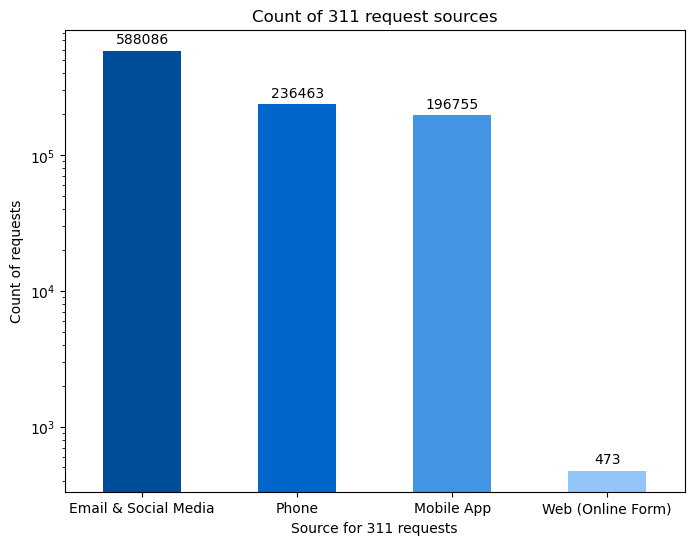

In [1262]:
# Get the count of each unique value in the 'source' column
source_counts = pd.DataFrame(efficiencyDF['source'].value_counts())
print("Unique 311 request sources are:")
display(source_counts)

# Create a bar chart with a logarithmic scale
plt.figure(figsize=(8, 6))
ax = source_counts['count'].plot(kind='bar', color=['#004D99', '#0066CC', '#4394E5', '#92C5F9'])
plt.xlabel('Source for 311 requests')
plt.ylabel('Count of requests')
plt.title('Count of 311 request sources')
plt.yscale('log')
plt.xticks(rotation=0)
# Add count values on top of the bars
for i in ax.patches:
    ax.annotate(str(i.get_height()), (i.get_x() + i.get_width() / 2, i.get_height()), ha='center', va='center', xytext=(0, 8), textcoords='offset points')

plt.show()

## Request Volume and Trends Analysis

• Yearly/Monthly Trends: 

      Analyze the number of service requests over different years and months to identify trends and seasonal patterns.

• Daily Trends: Analyze requests by day of the week to understand if there's an increase on weekends or specific weekdays.

request_year
2023    535281
2024    486496
dtype: int64

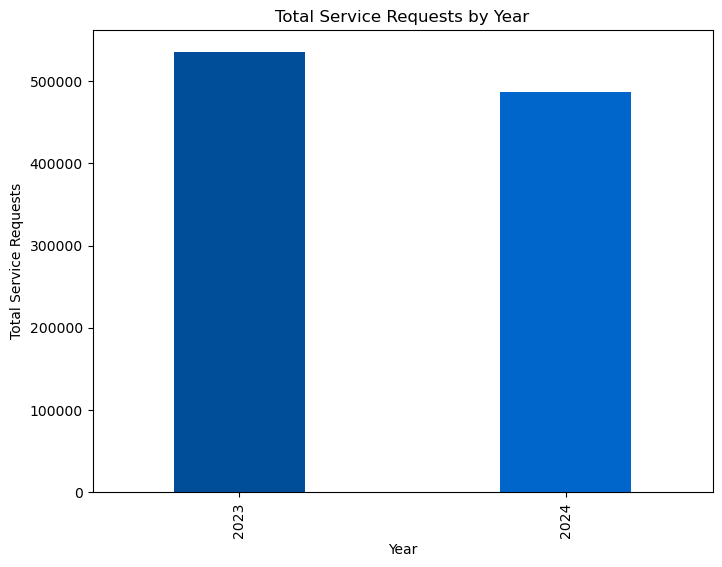

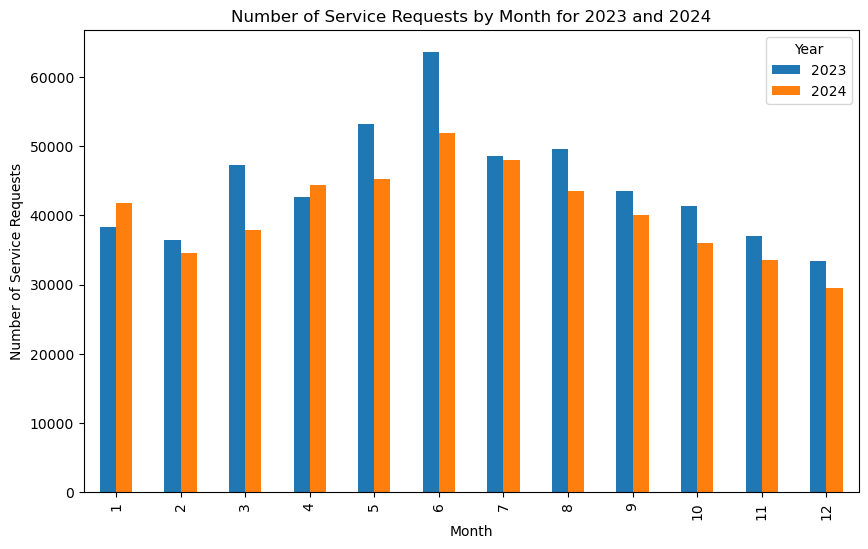

request_year,2023,2024
request_month,,
1,38333,41816
2,36471,34499
3,47350,37847
4,42674,44429
5,53256,45261
6,63642,51872
7,48610,48070
8,49601,43578
9,43588,40045


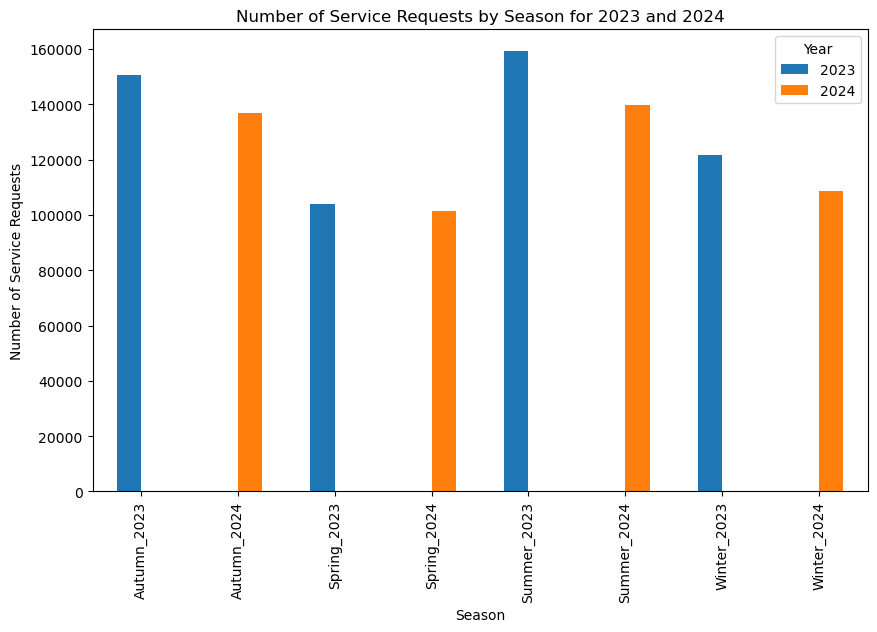

,Season,request_year,service_request_count
0,Autumn_2023,2023,150747
1,Autumn_2024,2024,136768
2,Spring_2023,2023,103924
3,Spring_2024,2024,101249
4,Summer_2023,2023,159079
5,Summer_2024,2024,139805
6,Winter_2023,2023,121531
7,Winter_2024,2024,108674


In [1264]:
# Aggregate the data by year and month
yearly_data = efficiencyDF.groupby('request_year').size()
display(yearly_data)
# Plot the number of service requests by year
plt.figure(figsize=(8, 6))
yearly_data.plot(kind='bar', color=['#004D99', '#0066CC'], width = 0.40)
plt.xlabel('Year')
plt.ylabel('Total Service Requests')
plt.title('Total Service Requests by Year')
plt.show()

# Filter the data for the years 2023 and 2024
efficiencyDF_filtered = efficiencyDF[(efficiencyDF['request_year'] == 2023) | (efficiencyDF['request_year'] == 2024)]
# Group by year and month and count the number of service requests
monthly_trends = efficiencyDF_filtered.groupby(['request_year', 'request_month']).size().reset_index(name='service_request_count')
# Pivot the table to make it easier to plot
monthly_trends_pivot = monthly_trends.pivot(index='request_month', columns='request_year', values='service_request_count')
monthly_trends_pivot.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Month')
plt.ylabel('Number of Service Requests')
plt.title('Number of Service Requests by Month for 2023 and 2024')
plt.legend(title='Year')
plt.show()

# Display the result
display(monthly_trends_pivot)


# Group by season and year and count the number of service requests
seasonal_trends = efficiencyDF_filtered.groupby(['Season', 'request_year']).size().reset_index(name='service_request_count')
# Pivot the table to make it easier to plot
seasonal_trends_pivot = seasonal_trends.pivot(index='Season', columns='request_year', values='service_request_count')
# Plotting with custom bar width
seasonal_trends_pivot.plot(kind='bar', figsize=(10, 6), width =0.5)
plt.xlabel('Season')
plt.ylabel('Number of Service Requests')
plt.title('Number of Service Requests by Season for 2023 and 2024')
plt.legend(title='Year')
plt.show()

# Display the result
display(seasonal_trends)



<Figure size 1000x800 with 0 Axes>

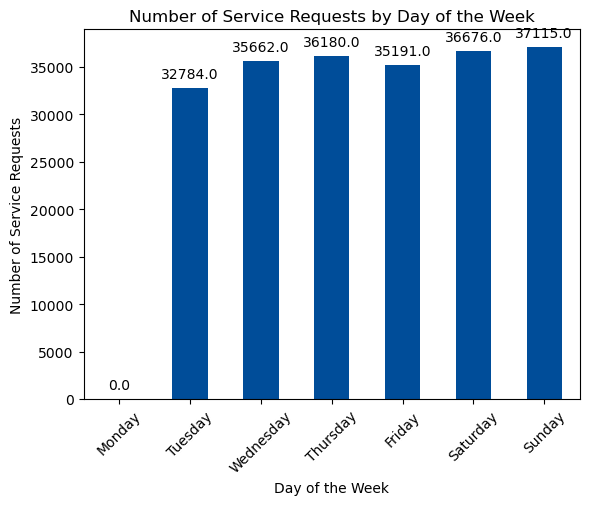

    day_name  service_request_count
0     Monday                    NaN
1    Tuesday               32784.00
2  Wednesday               35662.00
3   Thursday               36180.00
4     Friday               35191.00
5   Saturday               36676.00
6     Sunday               37115.00
    day_name  weekend_service_request_count
0     Monday                            NaN
1    Tuesday                            NaN
2  Wednesday                            NaN
3   Thursday                            NaN
4     Friday                            NaN
5   Saturday                       35320.00
6     Sunday                       35713.00


In [1265]:
# Map the numerical days to their names for better readability
day_name_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['day_name'] = df['request_day'].map(day_name_map)

# Group by day_name and count the number of service requests
daily_trends = df.groupby('day_name').size().reindex(day_name_map.values()).reset_index(name='service_request_count')

# Plotting the daily trends
plt.figure(figsize=(10, 8))
ax = daily_trends.plot(kind='bar', x='day_name', y='service_request_count', legend=False, color='#004D99', width=0.5)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Service Requests')
plt.title('Number of Service Requests by Day of the Week')

# Add the count on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.xticks(rotation=45)
plt.show()

# Display the result
print(daily_trends)

# Analyze the weekend requests
weekend_requests = efficiencyDF[efficiencyDF['is_weekend_request']]
weekend_trends = weekend_requests.groupby('day_name').size().reindex(day_name_map.values()).reset_index(name='weekend_service_request_count')
print(weekend_trends)


## Trends Over Time 

• How has the volume and type of service requests changed over the years?

• Are there noticeable trends in requests that could be used for future planning?


In [1267]:
display(efficiencyDF.columns)
comm_code_counts = df['service_name'].value_counts().sort_values(ascending=False)
display(comm_code_counts.head(10))

same_division_df = efficiencyDF[efficiencyDF['agency_division'] == efficiencyDF['agency_subdivision']]
display(same_division_df)

same_division_df = efficiencyDF[efficiencyDF['agency_division'] == 'Corporate Wide Service Requests']
display(same_division_df)

file_path = '/Users/anithajoseph/Documents/UofC/DATA601/Project_Proposal/ProposalDocs/service_requests.csv'

comm_code_counts = efficiencyDF['service_category'].value_counts().sort_values(ascending=False)
display(comm_code_counts.head(20))
# Write the DataFrame to a CSV file
#comm_code_counts.to_csv(file_path, index=False)

comm_code_counts = df['agency_subdivision'].value_counts().sort_values(ascending=False)
display(comm_code_counts)




comm_code_counts = df['service_name'].value_counts().sort_values(ascending=False)
display(comm_code_counts.head(10))

Index(['service_request_id', 'requested_date', 'updated_date', 'closed_date',
       'status_description', 'source', 'service_name', 'agency_responsible',
       'comm_code', 'comm_name', 'location_type', 'longitude', 'latitude',
       'point', 'request_year', 'request_month', 'request_day', 'update_year',
       'update_month', 'update_day', 'closed_year', 'closed_month',
       'closed_day', 'day_name', 'is_weekend_request', 'response_time',
       'duplicate_request', 'new_requested_date', 'Season', 'community_sector',
       'agency_division', 'agency_subdivision', 'service_category',
       'service_request', 'is_in_subdivision'],
      dtype='object')

service_name
WRS - Cart Management                      48307
Finance - Property Tax Account Inquiry     37463
Bylaw - Snow and Ice on Sidewalk           32435
Finance - ONLINE TIPP Agreement Request    28318
Corporate - Graffiti Concerns              21235
Roads - Pothole Maintenance                21202
311 Contact Us                             20377
AT - Property Tax Account Inquiry          18704
Roads - Snow and Ice Control               18648
Bylaw - Long Grass - Weeds Infraction      17157
Name: count, dtype: int64

,service_request_id,requested_date,updated_date,closed_date,status_description,source,service_name,agency_responsible,comm_code,comm_name,...,response_time,duplicate_request,new_requested_date,Season,community_sector,agency_division,agency_subdivision,service_category,service_request,is_in_subdivision
46,23-00002533,2023-01-02,2023-01-03,2023-01-03,Closed,Phone,Opinions on Business Units,Corporate Wide Service Requests,Community Centrepoint,Community Centrepoint,...,1.00,No,2023-01-02 00:00:00-07:00,Spring_2023,Community Centrepoint,Corporate Wide Service Requests,Corporate Wide Service Requests,Opinions on Business Units,Opinions on Business Units,False
107,23-00001983,2023-01-02,2023-01-02,2023-01-02,Closed,Email & Social Media,Opinions on Business Units,Corporate Wide Service Requests,Community Centrepoint,Community Centrepoint,...,0.00,No,2023-01-02 00:00:00-07:00,Spring_2023,Community Centrepoint,Corporate Wide Service Requests,Corporate Wide Service Requests,Opinions on Business Units,Opinions on Business Units,False
196,23-00001593,2023-01-02,2023-01-13,2023-01-13,Closed,Phone,Partnerships - Arts and Culture,Partnerships,Community Centrepoint,Community Centrepoint,...,11.00,No,2023-01-02 00:00:00-07:00,Spring_2023,Community Centrepoint,Partnerships,Partnerships,Partnerships,Arts and Culture,True
234,23-00002018,2023-01-02,2023-01-02,2023-01-02,Closed,Email & Social Media,Opinions on Business Units,Corporate Wide Service Requests,Community Centrepoint,Community Centrepoint,...,0.00,No,2023-01-02 00:00:00-07:00,Spring_2023,Community Centrepoint,Corporate Wide Service Requests,Corporate Wide Service Requests,Opinions on Business Units,Opinions on Business Units,False
310,23-00002885,2023-01-02,2023-01-02,2023-01-02,Closed,Phone,Opinions on Business Units,Corporate Wide Service Requests,Community Centrepoint,Community Centrepoint,...,0.00,No,2023-01-02 00:00:00-07:00,Spring_2023,Community Centrepoint,Corporate Wide Service Requests,Corporate Wide Service Requests,Opinions on Business Units,Opinions on Business Units,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061471,24-00975603,2024-12-30,2025-01-02,2025-01-02,Closed,Email & Social Media,Opinions on Business Units,Corporate Wide Service Requests,Community Centrepoint,Community Centrepoint,...,3.00,No,2024-12-30 00:00:00-07:00,Winter_2024,Community Centrepoint,Corporate Wide Service Requests,Corporate Wide Service Requests,Opinions on Business Units,Opinions on Business Units,False
1061477,24-00975616,2024-12-30,2024-12-30,2024-12-30,Closed,Email & Social Media,Opinions on Business Units,Corporate Wide Service Requests,Community Centrepoint,Community Centrepoint,...,0.00,No,2024-12-30 00:00:00-07:00,Winter_2024,Community Centrepoint,Corporate Wide Service Requests,Corporate Wide Service Requests,Opinions on Business Units,Opinions on Business Units,False
1062170,24-00978865,2024-12-31,2024-12-31,2024-12-31,Closed,Email & Social Media,Opinions on Business Units,Corporate Wide Service Requests,Community Centrepoint,Community Centrepoint,...,0.00,No,2024-12-31 00:00:00-07:00,Winter_2024,Community Centrepoint,Corporate Wide Service Requests,Corporate Wide Service Requests,Opinions on Business Units,Opinions on Business Units,False
1062323,24-00978899,2024-12-31,2025-01-02,2025-01-02,Closed,Email & Social Media,Opinions on Business Units,Corporate Wide Service Requests,Community Centrepoint,Community Centrepoint,...,2.00,No,2024-12-31 00:00:00-07:00,Winter_2024,Community Centrepoint,Corporate Wide Service Requests,Corporate Wide Service Requests,Opinions on Business Units,Opinions on Business Units,False


,service_request_id,requested_date,updated_date,closed_date,status_description,source,service_name,agency_responsible,comm_code,comm_name,...,response_time,duplicate_request,new_requested_date,Season,community_sector,agency_division,agency_subdivision,service_category,service_request,is_in_subdivision
46,23-00002533,2023-01-02,2023-01-03,2023-01-03,Closed,Phone,Opinions on Business Units,Corporate Wide Service Requests,Community Centrepoint,Community Centrepoint,...,1.00,No,2023-01-02 00:00:00-07:00,Spring_2023,Community Centrepoint,Corporate Wide Service Requests,Corporate Wide Service Requests,Opinions on Business Units,Opinions on Business Units,False
107,23-00001983,2023-01-02,2023-01-02,2023-01-02,Closed,Email & Social Media,Opinions on Business Units,Corporate Wide Service Requests,Community Centrepoint,Community Centrepoint,...,0.00,No,2023-01-02 00:00:00-07:00,Spring_2023,Community Centrepoint,Corporate Wide Service Requests,Corporate Wide Service Requests,Opinions on Business Units,Opinions on Business Units,False
234,23-00002018,2023-01-02,2023-01-02,2023-01-02,Closed,Email & Social Media,Opinions on Business Units,Corporate Wide Service Requests,Community Centrepoint,Community Centrepoint,...,0.00,No,2023-01-02 00:00:00-07:00,Spring_2023,Community Centrepoint,Corporate Wide Service Requests,Corporate Wide Service Requests,Opinions on Business Units,Opinions on Business Units,False
310,23-00002885,2023-01-02,2023-01-02,2023-01-02,Closed,Phone,Opinions on Business Units,Corporate Wide Service Requests,Community Centrepoint,Community Centrepoint,...,0.00,No,2023-01-02 00:00:00-07:00,Spring_2023,Community Centrepoint,Corporate Wide Service Requests,Corporate Wide Service Requests,Opinions on Business Units,Opinions on Business Units,False
449,23-00001700,2023-01-02,2023-01-02,2023-01-02,Closed,Email & Social Media,Opinions on Business Units,Corporate Wide Service Requests,Community Centrepoint,Community Centrepoint,...,0.00,No,2023-01-02 00:00:00-07:00,Spring_2023,Community Centrepoint,Corporate Wide Service Requests,Corporate Wide Service Requests,Opinions on Business Units,Opinions on Business Units,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061471,24-00975603,2024-12-30,2025-01-02,2025-01-02,Closed,Email & Social Media,Opinions on Business Units,Corporate Wide Service Requests,Community Centrepoint,Community Centrepoint,...,3.00,No,2024-12-30 00:00:00-07:00,Winter_2024,Community Centrepoint,Corporate Wide Service Requests,Corporate Wide Service Requests,Opinions on Business Units,Opinions on Business Units,False
1061477,24-00975616,2024-12-30,2024-12-30,2024-12-30,Closed,Email & Social Media,Opinions on Business Units,Corporate Wide Service Requests,Community Centrepoint,Community Centrepoint,...,0.00,No,2024-12-30 00:00:00-07:00,Winter_2024,Community Centrepoint,Corporate Wide Service Requests,Corporate Wide Service Requests,Opinions on Business Units,Opinions on Business Units,False
1062170,24-00978865,2024-12-31,2024-12-31,2024-12-31,Closed,Email & Social Media,Opinions on Business Units,Corporate Wide Service Requests,Community Centrepoint,Community Centrepoint,...,0.00,No,2024-12-31 00:00:00-07:00,Winter_2024,Community Centrepoint,Corporate Wide Service Requests,Corporate Wide Service Requests,Opinions on Business Units,Opinions on Business Units,False
1062323,24-00978899,2024-12-31,2025-01-02,2025-01-02,Closed,Email & Social Media,Opinions on Business Units,Corporate Wide Service Requests,Community Centrepoint,Community Centrepoint,...,2.00,No,2024-12-31 00:00:00-07:00,Winter_2024,Community Centrepoint,Corporate Wide Service Requests,Corporate Wide Service Requests,Opinions on Business Units,Opinions on Business Units,False


service_category
Roads                         152775
WRS                           135140
Bylaw                         111281
Parks                          92151
Finance                        87306
WATS                           74463
CBS Inspection                 41782
DBBS Inspection                40874
CT                             38150
Corporate                      36849
AT                             24682
CFD                            24368
AS                             23602
RSP                            23040
DBBS                           16675
Recreation                     16384
311 Contact Us                 10487
GFL                             6747
CT AC                           5980
Opinions on Business Units      4970
Name: count, dtype: int64

agency_subdivision
 Emergency Management and Community Safety      162641
 Mobility                                       156710
 Waste and Recycling Services                   141893
 Assessment and Tax                              90788
 Development, Business and Building Services     84685
                                                 ...  
Affiliated Organizations                             5
Fleet and Inventory                                  4
 Calgary Parking Authority                           4
 Calgary Approvals Coordination                      1
 Utilities & Environmental Protection                1
Name: count, Length: 63, dtype: int64

service_name
WRS - Cart Management                      48307
Finance - Property Tax Account Inquiry     37463
Bylaw - Snow and Ice on Sidewalk           32435
Finance - ONLINE TIPP Agreement Request    28318
Corporate - Graffiti Concerns              21235
Roads - Pothole Maintenance                21202
311 Contact Us                             20377
AT - Property Tax Account Inquiry          18704
Roads - Snow and Ice Control               18648
Bylaw - Long Grass - Weeds Infraction      17157
Name: count, dtype: int64

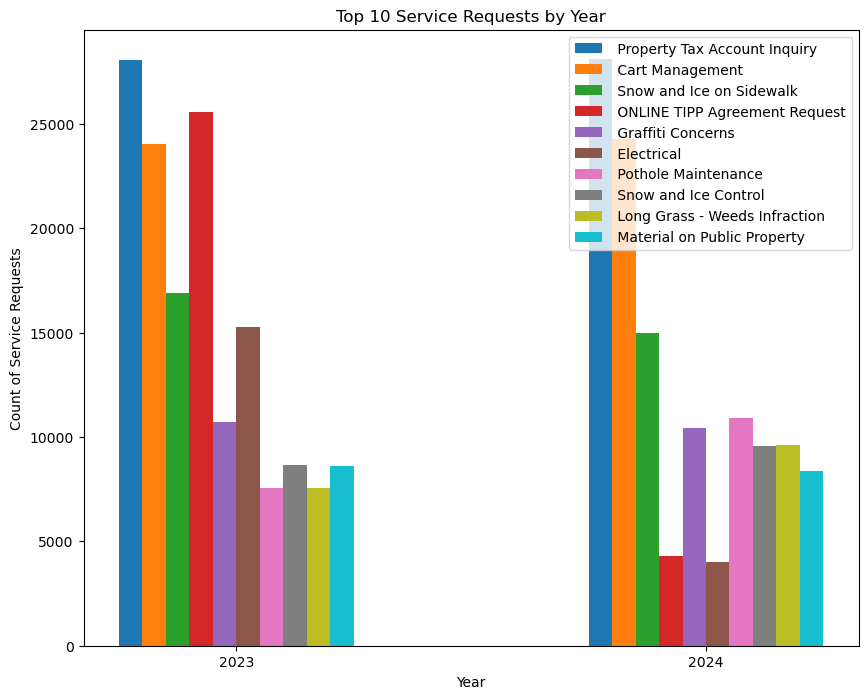

In [1268]:
# Aggregate the data by year and service type
aggregated_data = efficiencyDF.groupby(['request_year', 'service_request']).size().unstack(fill_value=0)

# Get the top 10 service names by their total counts
top_10_services = aggregated_data.sum(axis=0).nlargest(10).index

# Filter the aggregated_data to only include the top 10 services
top_10_aggregated_data = aggregated_data[top_10_services]

# Plotting the grouped bar chart
years = top_10_aggregated_data.index
service_names = top_10_aggregated_data.columns

bar_width = 0.05
index = np.arange(len(years))

fig, ax = plt.subplots(figsize=(10, 8))

for i, service_name in enumerate(service_names):
    ax.bar(index + i * bar_width, top_10_aggregated_data[service_name], bar_width, label=service_name)

ax.set_xlabel('Year')
ax.set_ylabel('Count of Service Requests')
ax.set_title('Top 10 Service Requests by Year')
ax.set_xticks(index + bar_width * (len(service_names) - 1) / 2)
ax.set_xticklabels(years)
ax.legend()

plt.show()
#display(efficiencyDF.columns)  service_category   service_request   service_name

In [1269]:
contains_311 = df['service_name'].str.contains('311')
services_with_311 = df[contains_311]
distinct_agencies = services_with_311[['agency_responsible','agency_division','agency_subdivision']].drop_duplicates()

distinct_agencies_count = services_with_311.groupby(
    ['agency_responsible', 'agency_division', 'agency_subdivision']
).size().reset_index(name='count')

display(distinct_agencies_count)

count_contains_311 = contains_311.sum()

print(count_contains_311)


operationDF = df['agency_division'].str.contains('Operational Services and Compliance')
opDF = df[operationDF]
display(opDF)

,agency_responsible,agency_division,agency_subdivision,count
0,CFOD - Customer Services and Communications,Chief Financial Officer Department,Customer Services and Communications,3480
1,PICS - Customer Service and Communications,Project Information and Control Systems,Customer Service and Communications,16897


20377


,service_request_id,requested_date,updated_date,closed_date,status_description,source,service_name,agency_responsible,comm_code,comm_name,...,is_weekend_request,response_time,duplicate_request,new_requested_date,Season,community_sector,agency_division,agency_subdivision,service_category,service_request
3,23-00001191,2023-01-02,2024-05-19,2023-01-10,Closed,Email & Social Media,CT - Lost Property,OS - Calgary Transit,Community Centrepoint,Community Centrepoint,...,False,8.00,No,2023-01-02 00:00:00-07:00,Spring_2023,Community Centrepoint,Operational Services and Compliance,Calgary Transit,CT,Lost Property
15,23-00002282,2023-01-02,2023-07-14,2023-07-14,Closed,Email & Social Media,Parks - Parks and Open Spaces Bookings,OS - Parks and Open Spaces,Community Centrepoint,Community Centrepoint,...,False,193.00,No,2023-01-02 00:00:00-07:00,Spring_2023,Community Centrepoint,Operational Services and Compliance,Parks and Open Spaces,Parks,Parks and Open Spaces Bookings
19,23-00002893,2023-01-02,2024-05-19,2023-01-11,Closed,Email & Social Media,CT - Lost Property,OS - Calgary Transit,Community Centrepoint,Community Centrepoint,...,False,9.00,No,2023-01-02 00:00:00-07:00,Spring_2023,Community Centrepoint,Operational Services and Compliance,Calgary Transit,CT,Lost Property
66,23-00002649,2023-01-02,2024-05-19,2023-01-11,Closed,Email & Social Media,CT - Lost Property,OS - Calgary Transit,Community Centrepoint,Community Centrepoint,...,False,9.00,No,2023-01-02 00:00:00-07:00,Spring_2023,Community Centrepoint,Operational Services and Compliance,Calgary Transit,CT,Lost Property
68,23-00001680,2023-01-02,2024-05-18,2023-01-10,Closed,Email & Social Media,CT - Lost Property,OS - Calgary Transit,Community Centrepoint,Community Centrepoint,...,False,8.00,No,2023-01-02 00:00:00-07:00,Spring_2023,Community Centrepoint,Operational Services and Compliance,Calgary Transit,CT,Lost Property
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062910,24-00977888,2024-12-31,2025-01-21,2025-01-21,Closed,Email & Social Media,CT - Park and Ride Lot - LRT or Bus,OS - Calgary Transit,SUN,SUNRIDGE,...,True,21.00,No,2024-12-31 00:00:00-07:00,Winter_2024,NORTHEAST,Operational Services and Compliance,Calgary Transit,CT,Park and Ride Lot - LRT or Bus
1062913,24-00977541,2024-12-31,2025-01-27,2025-01-27,Closed,Email & Social Media,Roads - Detour Inquiry,OS - Mobility,BLN,BELTLINE,...,True,27.00,No,2024-12-31 00:00:00-07:00,Winter_2024,CENTRE,Operational Services and Compliance,Mobility,Roads,Detour Inquiry
1062916,24-00977260,2024-12-31,2025-01-21,2025-01-02,Open,Email & Social Media,WRS - Cart Management,OS - Waste and Recycling Services,HUN,HUNTINGTON HILLS,...,True,2.00,No,2024-12-31 00:00:00-07:00,Winter_2024,NORTH,Operational Services and Compliance,Waste and Recycling Services,WRS,Cart Management
1062917,24-00978925,2024-12-31,2025-01-21,2025-01-21,Closed,Email & Social Media,CT AC - Trip Feedback - CTA,OS - Calgary Transit,DNW,DOWNTOWN WEST END,...,True,21.00,No,2024-12-31 00:00:00-07:00,Winter_2024,CENTRE,Operational Services and Compliance,Calgary Transit,CT AC,Trip Feedback - CTA


In [1270]:

agency_division = df[['agency_division']]#['service_name']
print("Null agencies count: ", len(agency_division))
#nulldiv = nulldiv.drop_duplicates()
display(agency_division)

ss=df

distinct_values = ss[['agency_responsible','service_name', 'agency_division',  
                      'agency_subdivision', 'service_category','service_request']].drop_duplicates()


#print("Distinct agency_responsible and new_serviceNames for 'Active Living Program Application':")
display(distinct_values)


# Get the counts of each comm_code and sort them in descending order
selectedService = df['service_request'].value_counts().sort_values(ascending=False).index
# Select rows for the sorted comm_code and display specific columns
selected_columns = ['service_category', 'service_request', 'service_name']
sorted_df = df[df['service_request'].isin(selectedService)][selected_columns]
display(sorted_df.head(10))

Null agencies count:  1062919


,agency_division
0,Chief Financial Officer Department
1,Community Services
2,Community Services
3,Operational Services and Compliance
4,Community Services
...,...
1062914,Planning & Development Services
1062915,Community Services
1062916,Operational Services and Compliance
1062917,Operational Services and Compliance


,agency_responsible,service_name,agency_division,agency_subdivision,service_category,service_request
0,CFOD - Finance,Finance - ONLINE TIPP Agreement Request,Chief Financial Officer Department,Finance,Finance,ONLINE TIPP Agreement Request
1,CS - Recreation and Social Programs,Active Living Program Application,Community Services,Recreation and Social Programs,Active Living Program Application,Active Living Program Application
2,CS - Calgary Neighbourhoods,CN - Registered Social Worker Letter,Community Services,Calgary Neighbourhoods,CN,Registered Social Worker Letter
3,OS - Calgary Transit,CT - Lost Property,Operational Services and Compliance,Calgary Transit,CT,Lost Property
4,CS - Calgary Recreation,Recreation - Arena Booking Application,Community Services,Calgary Recreation,Recreation,Arena Booking Application
...,...,...,...,...,...,...
1051794,IS - Public Spaces Delivery,PSD - Bridges and Structures Inquiry,Information Services,Public Spaces Delivery,PSD,Bridges and Structures Inquiry
1052768,OSC - Operational Services and Compliance,CPI - Plus 15 Skywalk,Operational Services and Compliance,Operational Services and Compliance,CPI,Plus 15 Skywalk
1060614,IS - Public Spaces Delivery,PSD - Major Transit Projects Inquiry,Information Services,Public Spaces Delivery,PSD,Major Transit Projects Inquiry
1061503,OSC - Operational Services and Compliance,CPI - Future Road Planning and Upgrades,Operational Services and Compliance,Operational Services and Compliance,CPI,Future Road Planning and Upgrades


,service_category,service_request,service_name
0,Finance,ONLINE TIPP Agreement Request,Finance - ONLINE TIPP Agreement Request
1,Active Living Program Application,Active Living Program Application,Active Living Program Application
2,CN,Registered Social Worker Letter,CN - Registered Social Worker Letter
3,CT,Lost Property,CT - Lost Property
4,Recreation,Arena Booking Application,Recreation - Arena Booking Application
5,Active Living Program Application,Active Living Program Application,Active Living Program Application
6,CT AC,Trip Feedback - CTA,CT AC - Trip Feedback - CTA
7,REC,Southland Leisure Centre Inquiry,REC - Southland Leisure Centre Inquiry
8,Parks,Snow and Ice Concerns - WAM,Parks - Snow and Ice Concerns - WAM
9,AS,Pick Up Stray,AS - Pick Up Stray
